In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# It works quite well with ~5000 articles: I could try more data and more trials for reproducibility
# Add on LoRA
# Try smaller BERT models?
# Evaluate on Russian dataset
# Rename variable names

In [ ]:
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import os
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import seaborn as sns
import matplotlib.pyplot as plt

import re

from collections import Counter

from pprint import pprint
import glob

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# read data
file_path_fake = '/content/drive/MyDrive/archive/DataSet_Misinfo_FAKE.csv'
file_path_true = '/content/drive/MyDrive/archive/DataSet_Misinfo_TRUE.csv'
# file_path_rus = '/content/drive/MyDrive/archive/EXTRA_RussianPropagandaSubset.csv'

input_text_fake = pd.read_csv(file_path_fake)
input_text_true = pd.read_csv(file_path_true)
# input_text_rus = pd.read_csv(file_path_rus)


In [ ]:
input_text_fake.insert(input_text_fake.shape[1], 'label', 1)
input_text_true.insert(input_text_true.shape[1], 'label', 0)

In [ ]:
input_text_true['text'][0]

'The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific researc

In [ ]:
input_text_fake['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

In [ ]:
input_text_fake = shuffle(input_text_fake)
input_text_fake = input_text_fake[0:2499]
input_text_true = shuffle(input_text_true)
input_text_true = input_text_true[0:2499]

print(input_text_fake.shape)
print(input_text_true.shape)

(2499, 3)
(2499, 3)


In [ ]:
input_text = pd.concat([input_text_fake, input_text_true], ignore_index=True)

input_text = input_text[['text', 'label']]
input_text = input_text.astype(str)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(input_text['text'], input_text['label'], test_size=0.1)

In [ ]:
train_labels.shape

(4498,)

In [ ]:
max_length = 500

In [ ]:

train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
train_inputs = [train_encodings.input_ids,
                train_encodings.token_type_ids,
                train_encodings.attention_mask]
train_labels = np.array(train_labels)

test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_inputs = [test_encodings.input_ids,
               test_encodings.token_type_ids,
               test_encodings.attention_mask]
test_labels = np.array(test_labels)


In [ ]:
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [ ]:
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=max_length,
                          hidden_size=100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    # cls_token = bert_out[0][:, 0, :]
    reduced_bert_out = tf.math.reduce_mean(bert_out[0], axis=1)

    dropout = tf.keras.layers.Dropout(dropout, name='dropout_layer')(reduced_bert_out)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(dropout)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


In [ ]:
bert_cls_model = create_bert_cls_model(bert_model)

bert_cls_model_history = bert_cls_model.fit(train_inputs,
                                            train_labels,
                                            validation_data=(test_inputs, test_labels),
                                            batch_size=8,
                                            epochs=5
                                            )


Epoch 1/5


563/563 [==============================] - 610s 1s/step - loss: 0.1943 - accuracy: 0.9209 - val_loss: 0.0716 - val_accuracy: 0.9700
Epoch 2/5
563/563 [==============================] - 564s 1s/step - loss: 0.0757 - accuracy: 0.9755 - val_loss: 0.0568 - val_accuracy: 0.9800
Epoch 3/5
563/563 [==============================] - 564s 1s/step - loss: 0.0404 - accuracy: 0.9873 - val_loss: 0.0848 - val_accuracy: 0.9800
Epoch 4/5
563/563 [==============================] - 564s 1s/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0797 - val_accuracy: 0.9700
Epoch 5/5
563/563 [==============================] - 563s 1s/step - loss: 0.0403 - accuracy: 0.9876 - val_loss: 0.0918 - val_accuracy: 0.9740


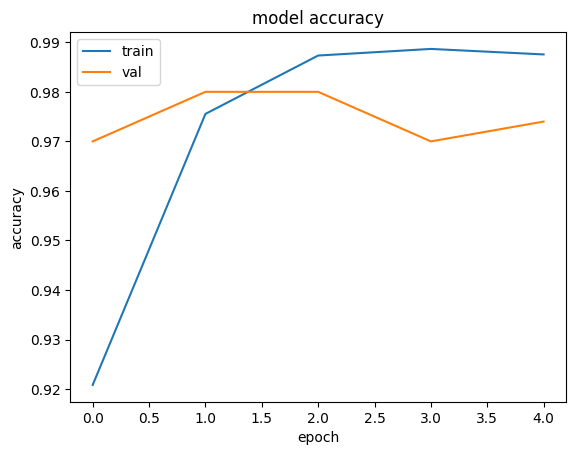

In [ ]:
plt.plot(bert_cls_model_history.history['accuracy'])
plt.plot(bert_cls_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
